# Testing my models on Robust ML

This notebook tests the robustness of saved models with a modified robustml attack.

The only thing modified about the robustml framework is that it returns output values so that confidence estimates can be plotted. The methods of generating noise has not been altered. 

I have included models that have trained with a softmax layer, and cross entropy cost function for a benchmark. Models are contained in a file that loads weights from a pickle file, this will be easier to use than any of my other notebooks because it does not use Parana, the framework made to analyse and prune models. I made parana, and it is surely buggy. 

Plots and tables are explained in more detail in the write up here.

In [1]:
import tensorflow as tf
import numpy as np
import ANN_CE
import ANN_LQ
import ANN_LQ_Pruned
import CNN_CE
import CNN_LQ
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
from tensorflow.examples.tutorials.mnist import input_data
import robustml
from attack import FGSMAttack
from attack import PGDAttack
from attack import NullAttack

class Robmodel(robustml.model.Model):
    def __init__(self, sess):
        self._sess = sess
        self._input = thismodel.inputs
        self._logits =  thismodel.output
        self._predictions = tf.argmax(thismodel.output, 1)
        self._dataset = robustml.dataset.MNIST()
        self._threat_model = robustml.threat_model.Linf(epsilon=0.1)
        
    @property
    def dataset(self):
        return self._dataset

    @property
    def threat_model(self):
        return self._threat_model

    def classify(self, x):
        return self._sess.run(self._predictions, {self._input: x})[0]
    
    def get_logit_output(self, x):
        return self._sess.run(thismodel.output, {self._input: x})
    # exposing some internals to make it less annoying for attackers to do a
    # white-box attack

    @property
    def input(self):
        return self._input

    @property
    def logits(self):
        return self._logits

    @property
    def predictions(self):
        return self._predictions
    

provider = robustml.provider.MNIST('MNIST_data/t10k-images-idx3-ubyte.gz', 'MNIST_data/t10k-labels-idx1-ubyte.gz')

C:\Users\Jim\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [2]:

datapoints = 1000

def get_corruption_rates():
    
    success_rate_fgsm, adv_output_fgsm = robustml.evaluate.evaluate(
        model,
        fgsmattack,
        provider,
        start=0,
        end=datapoints,
        deterministic=True,
        debug=False)
    print(success_rate_fgsm)
    success_rate_pgd, adv_output_pgd = robustml.evaluate.evaluate(
        model,
        pgdattack,
        provider,
        start=0,
        end=datapoints,
        deterministic=True,
        debug=False)
    print(success_rate_pgd)
    success_rate_none, adv_output_none = robustml.evaluate.evaluate(
        model,
        noattack,
        provider,
        start=0,
        end=datapoints,
        deterministic=True,
        debug=False)
    print(success_rate_none)
    return adv_output_fgsm, adv_output_pgd, adv_output_none



In [3]:
def confidonk(slist):
    conn = []
    for i in slist:
        stort = np.sort(i[0])
        conn.append(np.abs(stort[-1]/stort[-2]))
    return conn

def plot_cutoff(fgsm_noise, pgd_noise, no_noise, start, end, step):
    
    fgsm_noise_total = []
    pgd_noise_total = []
    cutoffs = []
    nonoise = []
    cutoff = start
    for i in range(int((end-start)/step)):
        fgsm_noise_total.append(sum([i>cutoff for i in fgsm_noise])/len(fgsm_noise))
        pgd_noise_total.append(sum([i>cutoff for i in pgd_noise])/len(pgd_noise))
        nonoise.append(sum([i>cutoff for i in no_noise])/len(no_noise))
        cutoffs.append(cutoff)
        cutoff += step
    return fgsm_noise_total, pgd_noise_total, nonoise, cutoffs


# Convoltional model, softmax-cross entropy

0.95
0.544
0.005


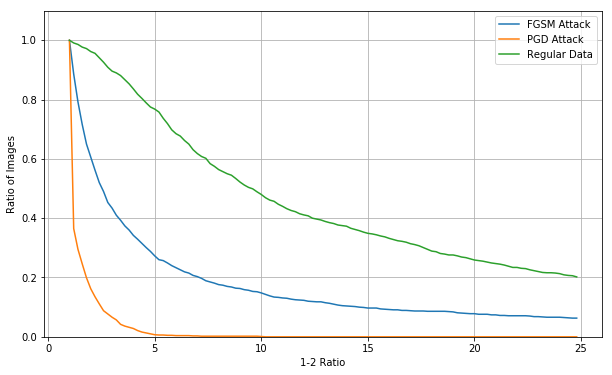

In [4]:
thismodel = CNN_CE

sess = tf.Session()

sess.run(tf.global_variables_initializer())

model = Robmodel(sess) 


fgsmattack = FGSMAttack(sess, model, model.threat_model.epsilon)
pgdattack = PGDAttack(sess, model, model.threat_model.epsilon)
noattack = NullAttack()

output_fgsm, output_pgd, output_none = get_corruption_rates()

fgsm_confidence = confidonk(output_fgsm)
pgd_confidence = confidonk(output_pgd)
nonoise_confidence = confidonk(output_none)

fgsmnoise, pgdnoise, goodnoise, cutoffs = plot_cutoff(fgsm_confidence, pgd_confidence,
                                 nonoise_confidence,
                                 start = 1, end = 25, step = 0.2)

plt.plot(cutoffs, fgsmnoise, label='FGSM Attack')
plt.plot(cutoffs, pgdnoise, label='PGD Attack')
plt.plot(cutoffs, goodnoise, label='Regular Data')
plt.ylim(0,1.1)
plt.xlabel('1-2 Ratio')
plt.ylabel('Ratio of Images')
plt.grid()
plt.legend()
plt.show()

sess.close()

# Convolutional model linear-quadratic

0.552
0.421
0.01


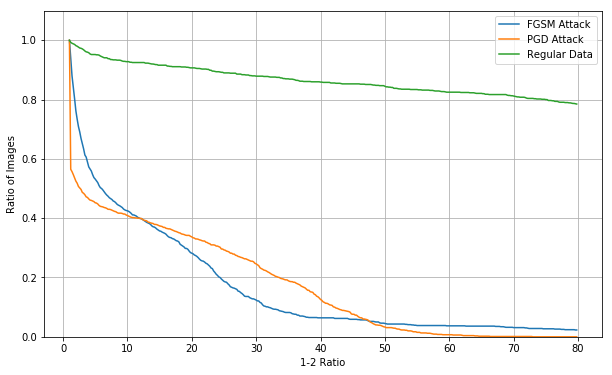

In [4]:
thismodel = CNN_LQ
sess = tf.Session()
sess.run(tf.global_variables_initializer())
model = Robmodel(sess) 

fgsmattack = FGSMAttack(sess, model, model.threat_model.epsilon)
pgdattack = PGDAttack(sess, model, model.threat_model.epsilon)
noattack = NullAttack()

output_fgsm, output_pgd, output_none = get_corruption_rates()

fgsm_confidence = confidonk(output_fgsm)
pgd_confidence = confidonk(output_pgd)
nonoise_confidence = confidonk(output_none)

fgsmnoise, pgdnoise, goodnoise, cutoffs = plot_cutoff(fgsm_confidence, pgd_confidence,
                                 nonoise_confidence,
                                 start = 1, end = 80, step = 0.2)

plt.plot(cutoffs, fgsmnoise, label='FGSM Attack')
plt.plot(cutoffs, pgdnoise, label='PGD Attack')
plt.plot(cutoffs, goodnoise, label='Regular Data')
plt.ylim(0,1.1)
plt.xlabel('1-2 Ratio')
plt.ylabel('Ratio of Images')
plt.grid()
plt.legend()
plt.show()

sess.close()

In [12]:
cutoff = 75
print(sum([i>cutoff for i in fgsm_confidence])/len(nonoise_confidence))
print(sum([i>cutoff for i in pgd_confidence])/len(nonoise_confidence))
print(sum([i>cutoff for i in nonoise_confidence])/len(nonoise_confidence))

0.027
0.0
0.8


# Fully connected model softmax-cross entropy

0.996
0.932
0.019


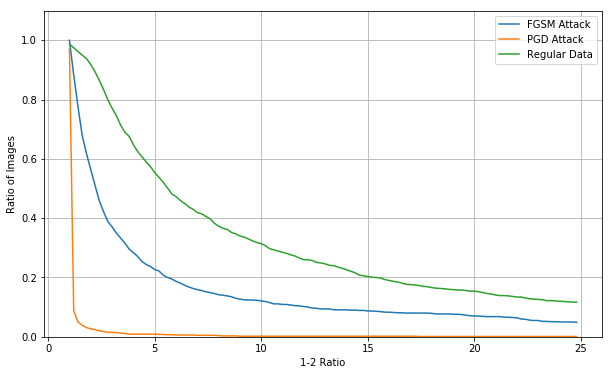

In [6]:
thismodel = ANN_CE
sess = tf.Session()
sess.run(tf.global_variables_initializer())
model = Robmodel(sess) 


fgsmattack = FGSMAttack(sess, model, model.threat_model.epsilon)
pgdattack = PGDAttack(sess, model, model.threat_model.epsilon)
noattack = NullAttack()

output_fgsm, output_pgd, output_none = get_corruption_rates()

fgsm_confidence = confidonk(output_fgsm)
pgd_confidence = confidonk(output_pgd)
nonoise_confidence = confidonk(output_none)

fgsmnoise, pgdnoise, goodnoise, cutoffs = plot_cutoff(fgsm_confidence, pgd_confidence,
                                 nonoise_confidence,
                                 start = 1, end = 25, step = 0.2)

plt.plot(cutoffs, fgsmnoise, label='FGSM Attack')
plt.plot(cutoffs, pgdnoise, label='PGD Attack')
plt.plot(cutoffs, goodnoise, label='Regular Data')
plt.ylim(0,1.1)
plt.xlabel('1-2 Ratio')
plt.ylabel('Ratio of Images')
plt.grid()
plt.legend()
plt.show()

sess.close()

# Fully connected model linear-quadratic

0.999
0.577
0.014


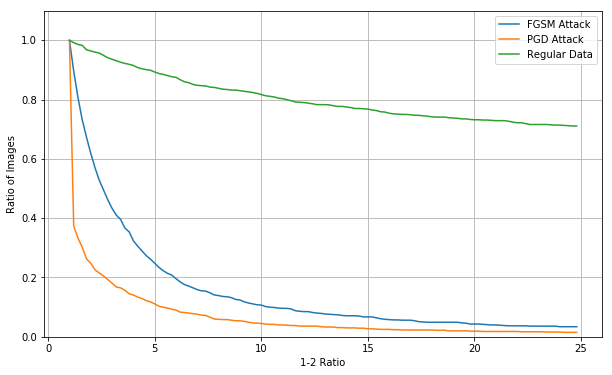

In [7]:
thismodel = ANN_LQ
sess = tf.Session()
sess.run(tf.global_variables_initializer())
model = Robmodel(sess) 

fgsmattack = FGSMAttack(sess, model, model.threat_model.epsilon)
pgdattack = PGDAttack(sess, model, model.threat_model.epsilon)
noattack = NullAttack()

output_fgsm, output_pgd, output_none = get_corruption_rates()

fgsm_confidence = confidonk(output_fgsm)
pgd_confidence = confidonk(output_pgd)
nonoise_confidence = confidonk(output_none)

fgsmnoise, pgdnoise, goodnoise, cutoffs = plot_cutoff(fgsm_confidence, pgd_confidence,
                                 nonoise_confidence,
                                 start = 1, end = 25, step = 0.2)

plt.plot(cutoffs, fgsmnoise, label='FGSM Attack')
plt.plot(cutoffs, pgdnoise, label='PGD Attack')
plt.plot(cutoffs, goodnoise, label='Regular Data')
plt.ylim(0,1.1)
plt.xlabel('1-2 Ratio')
plt.ylabel('Ratio of Images')
plt.grid()
plt.legend()
plt.show()

sess.close()

# Fully connected model linear-quadratic pruned

0.99
0.244
0.018


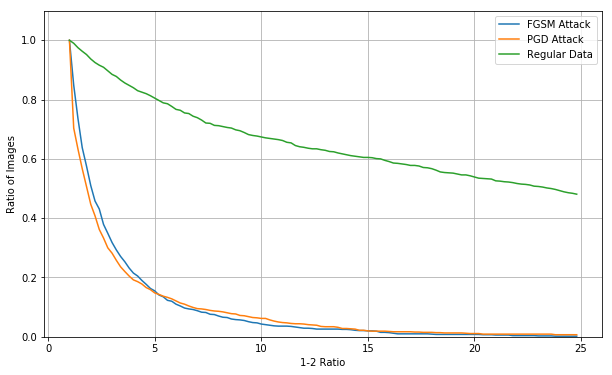

In [8]:
thismodel = ANN_LQ_Pruned
sess = tf.Session()
sess.run(tf.global_variables_initializer())
model = Robmodel(sess) 

fgsmattack = FGSMAttack(sess, model, model.threat_model.epsilon)
pgdattack = PGDAttack(sess, model, model.threat_model.epsilon)
noattack = NullAttack()

output_fgsm, output_pgd, output_none = get_corruption_rates()

fgsm_confidence = confidonk(output_fgsm)
pgd_confidence = confidonk(output_pgd)
nonoise_confidence = confidonk(output_none)

fgsmnoise, pgdnoise, goodnoise, cutoffs = plot_cutoff(fgsm_confidence, pgd_confidence,
                                 nonoise_confidence,
                                 start = 1, end = 25, step = 0.2)

plt.plot(cutoffs, fgsmnoise, label='FGSM Attack')
plt.plot(cutoffs, pgdnoise, label='PGD Attack')
plt.plot(cutoffs, goodnoise, label='Regular Data')
plt.ylim(0,1.1)
plt.xlabel('1-2 Ratio')
plt.ylabel('Ratio of Images')
plt.grid()
plt.legend()
plt.show()

sess.close()

# Corruption rates

Here are plots for corruption rates for different epsilon values for all the models tested. These weren't automated, I just did it manually. 

First is fully connected models, second is convolutional models. 

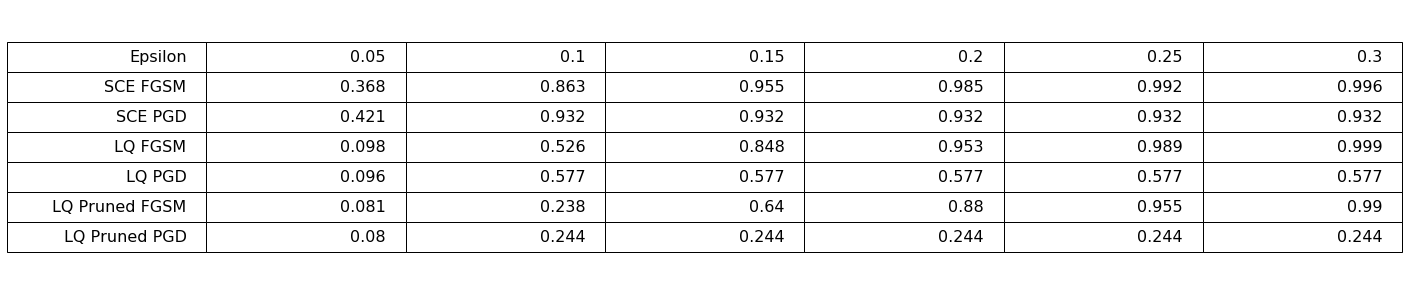

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

epsilon =        ['Epsilon', 0.05,  0.1,   0.15,   0.2,   0.25,  0.3]
SCE_FGSM =       ['SCE FGSM', 0.368, 0.863, 0.955, 0.985, 0.992, 0.996]
SCE_PGD =        ['SCE PGD', 0.421, 0.932, 0.932, 0.932, 0.932, 0.932]
LQ_FGSM =        ['LQ FGSM', 0.098, 0.526, 0.848, 0.953, 0.989, 0.999]
LQ_PGD =         ['LQ PGD', 0.096, 0.577, 0.577, 0.577, 0.577, 0.577]
LQ_Pruned_FGSM = ['LQ Pruned FGSM', 0.081, 0.238, 0.64, 0.88, 0.955, 0.99]
LQ_Pruned_PGD =  ['LQ Pruned PGD', 0.08, 0.244, 0.244, 0.244, 0.244, 0.244]

all_noisey_accuracies = np.concatenate([[epsilon, SCE_FGSM, SCE_PGD, LQ_FGSM, LQ_PGD, LQ_Pruned_FGSM, LQ_Pruned_PGD]])
all_performances = pd.DataFrame(all_noisey_accuracies)

fig = plt.figure(figsize=(10,5))
table = plt.table(cellText = all_performances.values,
                  loc='center')

table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(2.5, 2.5)
plt.axis('off')
plt.grid('off')
plt.show()

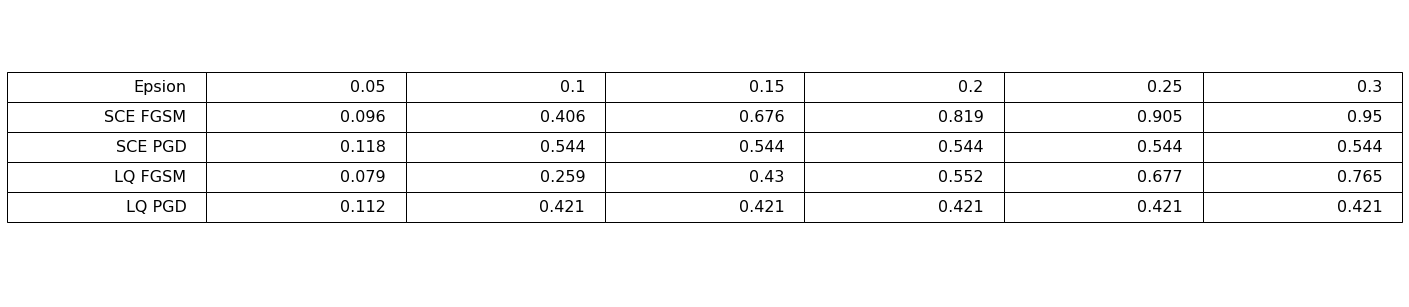

In [2]:
import pandas as pd
import numpy as np

epsilon = ['Epsion', 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
SCE_FGSM = ['SCE FGSM', 0.096, 0.406, 0.676, 0.819, 0.905, 0.95]
SCE_PGD = ['SCE PGD', 0.118, 0.544, 0.544, 0.544, 0.544, 0.544]
LQ_FGSM = ['LQ FGSM', 0.079, 0.259, 0.43, 0.552,0.677, 0.765]
LQ_PGD = ['LQ PGD', 0.112, 0.421, 0.421, 0.421, 0.421, 0.421]

all_noisey_accuracies = np.concatenate([[epsilon, SCE_FGSM, SCE_PGD, LQ_FGSM, LQ_PGD]])
all_performances = pd.DataFrame(all_noisey_accuracies)

fig = plt.figure(figsize=(10,5))
table = plt.table(cellText = all_performances.values,
                  loc='center')

table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(2.5, 2.5)
plt.axis('off')
plt.grid('off')
plt.show()

# The headline results:
Fully connected networks:
Improving from more than 93% corrupted to 24% corrupted on PGD with epsilon 0.3
improveing from 95% corrupted to 64% corrupted on FGSM with an epsilon of 0.15

Convolutional networks:
Rejecting 100% of pgd and 97.3% of FGSM noise while rejecting 20% of valid inputs
